In [1]:

# Import necessary libraries
from nltk import SnowballStemmer
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy import stats
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from pyodbc import lowercase
from textblob import TextBlob
import spacy
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from spacy.lang.en.examples import sentences
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Define a stemming tokenizer function
def stemming_tokenizer(str_input):
    """
    This function takes a string input and returns a list of stemmed words.
    """
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()
    words = [snow_stemmer.stem(word) for word in words]
    return words

# Define a function to create a document frequency matrix
def TAB_dfm(text, ngrams_range = (1,2), stop_words = 'english', min_prop = .01, max_features=None):
    """
    This function takes a text input and returns a document frequency matrix and a matrix.
    """
    if stop_words == 'english':
        vec = CountVectorizer(
            tokenizer = stemming_tokenizer,
            stop_words = stop_words,
            ngram_range=ngrams_range,
            min_df=min_prop,
            max_features=max_features,
            token_pattern='(?u)\\b\\w+\\b'
            )
    else:
        vec = CountVectorizer(
            tokenizer = stemming_tokenizer,
            ngram_range=ngrams_range,
            min_df=min_prop,
            max_features=max_features,
            token_pattern='(?u)\\b\\w+\\b'
        )

    mtx = vec.fit_transform(text).todense()
    df = round(pd.DataFrame(mtx, columns=vec.get_feature_names_out()),2)
    return df, mtx

# Define a function to calculate Kendall's tau accuracy
def kendall_acc(x,y,percentage = True):
    """
    This function takes two inputs x and y and returns Kendall's tau accuracy.
    """
    tau, p_value = stats.kendalltau(x, y)
    tau_acc = .5+tau/2
    tau_se = np.sqrt((tau_acc*(1 - tau_acc))/len(x))
    report = pd.DataFrame([tau_acc, tau_acc - 1.96 * tau_se, tau_acc + 1.96 * tau_se],
                            index = ['acc', 'lower', 'upper']).T
    report = round(report,4)

    if percentage is True:
        report = report * 100

    return report

# Define a function to calculate Jaccard similarity
def jaccard_sim(str1, str2):
    """
    This function takes two string inputs and returns the Jaccard similarity.
    """
    a = set(stemming_tokenizer(str1))
    b = set(stemming_tokenizer(str2))
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Define a function to calculate Euclidean distance
def euclidian_dist(docs, y = 0):
    """
    This function takes a list of documents and an index y and returns a list of Euclidean distances.
    """
    _, features = np.asarray(TAB_dfm(docs))
    distances = [round(float(euclidean_distances([features[y]], [f])),2) for f in features]
    return distances

# Define a function to calculate cosine similarity
def cosine_sim(docs, y = 0):
    """
    This function takes a list of documents and an index y and returns a list of cosine similarities.
    """
    _, features = np.asarray(TAB_dfm(docs, stop_words = False))
    distances = [round(float(cosine_similarity([features[y]], [f])),2) for f in features]
    return distances

# Define a function to parse text using Spacy
def spacy_parse(text):
    """
    This function takes a text input and returns a DataFrame with parsed information.
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    rows = [[t.text, t.lemma_, t.pos_, t.tag_, t.dep_, spacy.explain(t.pos_), t.is_stop] for t in doc]
    cols = ("text", "lemma", "POS", "Tag","Dep","explain", "stopword")
    df = pd.DataFrame(rows, columns=cols)
    return df

# Define a function to parse lemmas
def lemmas_parse(text):
    """
    This function takes a text input and returns a string of lemmas.
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    lemmas = [t.lemma_ for t in doc
              if t.pos_ not in ('SPACE', 'PRON', 'PUNCT', 'NUM', 'SYM')
              if t.is_stop == False]
    return ' '.join(lemmas)

# Define a function to create a document frequency matrix from lemmas
def lemmas_dfm(texts):
    """
    This function takes a list of texts and returns a document frequency matrix of lemmas.
    """
    dfms_joined = pd.DataFrame()
    for text in texts:
        text = [lemmas_parse(text)]
        if len(text[0]) > 1:
            dfm, _ = TAB_dfm(text, ngrams_range=(0,1), stop_words = False)
            dfms_joined = dfms_joined.append(dfm)
    return dfms_joined

# Define a function to parse named entities
def ner_parse(text):
    """
    This function takes a text input and returns a DataFrame with parsed named entities.
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    rows = [[ent.text, ent.start_char, ent.end_char, ent.label_] for ent in doc.ents]
    cols = ("Text", "Start", "End", "Label")
    df = pd.DataFrame(rows, columns=cols)
    return df

# Define a function to filter and parse named entities
def ner_filter_parse(text):
    """
    This function takes a text input and returns a string of filtered named entities.
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    ents = [ent.text for ent in doc.ents
            if ent.label_ == 'GPE']
    return ' '.join(list(set(ents)))

# Define a function to create a document frequency matrix from named entities
def ner_dfm(texts):
    """
    This function takes a list of texts and returns a document frequency matrix of named entities.
    """
    dfms_joined = pd.DataFrame()
    for text in texts:
        text = [ner_filter_parse(text)]
        if len(text[0]) > 1:
            dfm, _ = TAB_dfm(text, ngrams_range=(0,1), stop_words = False)
            dfms_joined = dfms_joined.append(dfm)
    return dfms_joined

# Define a tokenizer function
def tokenizer(str_input):
    """
    This function takes a string input and returns a list of words.
    """
    words = re.sub(r"[^A-Za-z]", " ", str_input).lower().split()
    return words

# Define a function to create a document frequency matrix from a lookup dictionary
def dfm_lookup(text, dict_as_list, ngrams_range = (1,1), min_prop = .01, max_features=None):
    """
    This function takes a text input and a lookup dictionary and returns a document frequency matrix.
    """
    vec = CountVectorizer(
        tokenizer = tokenizer,
        stop_words = 'english',
        ngram_range=ngrams_range,
        min_df=min_prop,
        max_features=max_features,
        token_pattern='(?u)\\b\\w+\\b'
        )
    mtx = vec.fit_transform(text).todense()
    df = round(pd.DataFrame(mtx, columns=vec.get_feature_names_out()),2)
    df = df[df.columns.intersection(dict_as_list)]
    row_sums = df.sum(axis=1)
    return row_sums

'''This Python script is used for text processing and analysis. It includes functions for tokenizing and stemming text, creating document frequency matrices, calculating Kendall's tau accuracy, Jaccard similarity, Euclidean distance, and cosine similarity, parsing text and named entities using Spacy, and creating document frequency matrices from lemmas and named entities. It also includes a function for creating a document frequency matrix from a lookup dictionary.'''

In [2]:
# vecSmall.csv contains pre-trained word vectors for a small vocabulary.
vecSmall = pd.read_csv('vecSmall.csv', index_col= 0)

# wfFile.csv contains word frequency information for a specific corpus.
wfFile = pd.read_csv('wfFile.csv', index_col= 0)

# filtered_dataset.csv contains the main dataset for analysis. The 'low_memory' parameter is set to False to silence dtypes warning.
data = pd.read_csv('filtered_dataset.csv', index_col= 0, low_memory=False)

In [3]:
from sklearn.model_selection import ShuffleSplit

# Instantiate the ShuffleSplit class with 1 split, a test size of 40%, and a random state of 42 for reproducibility
# This will be used to create a random split of the data into training and testing sets
sss = ShuffleSplit(n_splits=1, test_size=0.4, random_state = 42)

# Get the number of splitting iterations in the cross-validator
# This is not necessary for the split but can be used to check the number of splits
sss.get_n_splits(data)

# Generate indices to split data into training and test set
# next() is used to get the next item from the iterator
train_index, test_index = next(sss.split(data))

# Use the generated indices to create the training set
# iloc is used for indexing via integers
data_train = data.iloc[train_index]

# Use the generated indices to create the test set
data_test = data.iloc[test_index]

In [4]:
# Import the lowercase function from the pyodbc library
from pyodbc import lowercase

# The following code is a Python equivalent to the vecCheck function in the vectorFunctions.R script

# Define a pipeline for projecting data into embedding space
# The pipeline consists of two steps:
# 1. TfidfVectorizer: This is used to convert the text data into a matrix of TF-IDF features.
#    The vocabulary is set to the index of the wfFile DataFrame and the lowercase parameter is set to False to keep uppercase characters.
# 2. TruncatedSVD: This is used for dimensionality reduction. It transforms the data to have the same number of dimensions as the pre-trained model.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=wfFile.index, lowercase=False)),  
    ('lsa', TruncatedSVD(n_components=vecSmall.shape[1])),  
])

In [5]:
# Fit the pipeline to the 'Consumer complaint narrative' column of the data DataFrame
# This step involves transforming the text data into a matrix of TF-IDF features and then reducing the dimensionality of the data
pipeline.fit(data['Consumer complaint narrative'])

# Transform the 'Consumer complaint narrative' column of the data DataFrame using the fitted pipeline
# This step involves projecting the data into the embedding space
vdat = pipeline.transform(data['Consumer complaint narrative'])

# Convert the embedded data into a DataFrame
# The column names are generated dynamically based on the number of dimensions in the embedded data
# Each column represents a dimension in the embedding space
vdat = pd.DataFrame(vdat, columns=[f'vec{i+1}' for i in range(vdat.shape[1])])

# Print the first 10 rows of the DataFrame
# This is used to check the transformed data
print(vdat.head(10))

       vec1      vec2      vec3      vec4      vec5      vec6      vec7  \
0  0.212466 -0.042737  0.084530  0.234582 -0.099773 -0.061637  0.058663   
1  0.329551 -0.031669 -0.051305 -0.084200  0.057401  0.038061  0.136886   
2  0.416767 -0.063856  0.078748  0.057971 -0.059908 -0.073256 -0.056827   
3  0.347848 -0.108581 -0.083247 -0.047303  0.275795 -0.014486  0.002261   
4  0.254178 -0.043507  0.020654  0.090618 -0.097636 -0.013794 -0.006343   
5  0.495647  0.115488  0.200288 -0.012283  0.032888  0.195938 -0.017173   
6  0.453418 -0.159387 -0.047675 -0.144897 -0.007143  0.039272 -0.045600   
7  0.506661 -0.204375 -0.125888 -0.139932 -0.015730 -0.080862 -0.099955   
8  0.476338  0.179721  0.241587  0.031774 -0.016536  0.017355  0.087907   
9  0.533134  0.111343  0.187160  0.031704  0.013873  0.188898  0.090014   

       vec8      vec9     vec10  ...    vec291    vec292    vec293    vec294  \
0  0.002035 -0.061615 -0.012355  ... -0.056009 -0.023768  0.008212  0.051264   
1  0.167399  0

In [6]:
# Select the training data from the transformed DataFrame 'vdat' using the training indices
vdat_train = vdat.iloc[train_index]

# Select the testing data from the transformed DataFrame 'vdat' using the testing indices
vdat_test = vdat.iloc[test_index]

In [7]:
vdat

,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,...,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299,vec300
0,0.212466,-0.042737,0.084530,0.234582,-0.099773,-0.061637,0.058663,0.002035,-0.061615,-0.012355,...,-0.056009,-0.023768,0.008212,0.051264,-0.027019,-0.017914,-0.015938,-0.064591,-0.005321,-0.006789
1,0.329551,-0.031669,-0.051305,-0.084200,0.057401,0.038061,0.136886,0.167399,0.085139,-0.040155,...,-0.043577,0.021924,-0.015487,-0.012814,0.024140,0.033581,-0.012936,0.023254,-0.002005,0.017582
2,0.416767,-0.063856,0.078748,0.057971,-0.059908,-0.073256,-0.056827,0.002724,0.164222,0.016892,...,-0.000930,-0.012280,0.039937,0.007553,-0.003732,0.001576,-0.012773,-0.019525,0.026564,0.031043
3,0.347848,-0.108581,-0.083247,-0.047303,0.275795,-0.014486,0.002261,0.001086,-0.116583,0.019575,...,0.005675,0.003537,0.002480,-0.014922,0.006931,-0.003875,0.008881,0.006380,-0.016759,-0.022547
4,0.254178,-0.043507,0.020654,0.090618,-0.097636,-0.013794,-0.006343,0.042713,-0.015163,-0.045401,...,-0.027610,0.008973,0.007670,0.054998,-0.004788,-0.024903,-0.003312,0.002332,0.033979,0.014821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55494,0.161414,-0.036910,-0.071791,-0.005227,0.108638,0.007475,-0.125491,0.069913,-0.135872,-0.025866,...,-0.007753,0.041925,-0.032772,0.031069,-0.001951,-0.028029,-0.014190,-0.010927,0.030418,0.032375
55495,0.582511,-0.159423,-0.021621,-0.058352,0.019498,0.098623,-0.051045,-0.039033,-0.140285,-0.017645,...,0.007366,-0.032530,0.009722,-0.003164,-0.019724,-0.008250,0.013761,-0.010729,0.017165,-0.016347
55496,0.417243,-0.134113,-0.088882,-0.136230,-0.024750,0.007203,-0.051164,-0.052207,-0.020424,0.027685,...,0.008735,-0.019747,0.012631,-0.045658,-0.017590,0.001285,-0.027635,-0.016317,-0.029945,-0.012813
55497,0.259505,-0.015983,-0.044274,0.131172,-0.068296,-0.085412,0.032562,0.038944,0.145036,-0.034650,...,-0.027390,-0.024985,0.000446,-0.016602,0.014518,0.012084,-0.000999,0.001971,-0.008067,0.007494


#############################################
# Train a vector classifier
#############################################

In [8]:
# Import the LabelEncoder class from the sklearn.preprocessing module
from sklearn.preprocessing import LabelEncoder

# Instantiate the LabelEncoder class
# This will be used to encode the 'Company public response' column in the data
le = LabelEncoder()

# Fit the encoder to the 'Company public response' column in the training data
# This step involves learning the levels of the factor
# Then transform the 'Company public response' column in the training data
# This step involves converting the levels into numerical labels
data_train['Company public response'] = le.fit_transform(data_train['Company public response'])

# Transform the 'Company public response' column in the testing data
# This step involves converting the levels into numerical labels using the fitted encoder
data_test['Company public response'] = le.transform(data_test['Company public response'])

# Import the Lasso class from the sklearn.linear_model module
from sklearn.linear_model import Lasso

# Instantiate the Lasso class with an alpha of 0.001
# This will be used to fit a Lasso model to the data
Lasso_vec = Lasso(alpha = 0.001)

# Fit the Lasso model to the training data
# The 'Company public response' column is the response variable and the 'vdat_train' DataFrame is the predictor variables
Lasso_vec.fit(vdat_train,  data_train['Company public response'])

# Predict the 'Company public response' column in the testing data using the fitted Lasso model
# The 'vdat_test' DataFrame is the predictor variables
test_predict = Lasso_vec.predict(vdat_test)

# Estimate the accuracy of the Lasso model using Kendall's tau
# The 'test_predict' array is the predicted response variable and the 'Company public response' column in the testing data is the actual response variable
vec_acc = kendall_acc(test_predict, data_test['Company public response'])

# Print the accuracy of the Lasso model
print(vec_acc)

     acc  lower  upper
0  64.11  63.48  64.74


/var/folders/2y/ktn1hrps3flfg5b_bszm_lk00000gn/T/ipykernel_10933/2181103015.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Company public response'] = le.fit_transform(data_train['Company public response'])
/var/folders/2y/ktn1hrps3flfg5b_bszm_lk00000gn/T/ipykernel_10933/2181103015.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Company public response'] = le.transform(data_test['Company public response'])


#############################################
# vector embeddings + ngrams
#############################################

In [9]:
# Create a document frequency matrix for the 'Consumer complaint narrative' column in the training data
# The TAB_dfm function is used to create the document frequency matrix
# The second output of the function is not needed, so it is ignored using '_'
data_dfm_train, _ = TAB_dfm(data_train['Consumer complaint narrative'])

# Create a document frequency matrix for the 'Consumer complaint narrative' column in the testing data
# The minimum proportion for a term to be included in the matrix is set to 0
data_dfm_test, _ = TAB_dfm(data_test['Consumer complaint narrative'], min_prop = 0)

# Create a list of the column names in the training and testing document frequency matrices
d = [list(data_dfm_train), list(data_dfm_test)]

# Find the intersection of the column names in the training and testing document frequency matrices
# This is done to ensure that both matrices have the same columns
col_heads = list(set.intersection(*map(set,d)))

# Update the training and testing document frequency matrices to only include the intersecting columns
# The indices are reset for consistency
data_dfm_train= data_dfm_train[col_heads].reset_index(drop = True)
data_dfm_test = data_dfm_test[col_heads].reset_index(drop = True)

# Reset the indices of the training and testing data in the 'vdat' DataFrame for consistency
vdat_train = vdat_train.reset_index(drop = True)
vdat_test = vdat_test.reset_index(drop = True)

# Combine the training data in the 'vdat' DataFrame and the training document frequency matrix into a single DataFrame
# The data is combined along the columns (axis = 1)
combined_x_train = pd.concat([vdat_train, data_dfm_train], axis = 1)

# Combine the testing data in the 'vdat' DataFrame and the testing document frequency matrix into a single DataFrame
# The data is combined along the columns (axis = 1)
combined_x_test = pd.concat([vdat_test, data_dfm_test], axis = 1)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 

In [10]:
print(vdat_train.shape)
print(data_dfm_train.shape)
print(combined_x_train.shape)

(33299, 300)
(33299, 1318)
(33299, 1618)


In [11]:
# Import the Lasso class from the sklearn.linear_model module
from sklearn.linear_model import Lasso

# Instantiate the Lasso class with an alpha of 0.001
# This will be used to fit a Lasso model to the data
lasso_all = Lasso(alpha = 0.001)

# Fit the Lasso model to the training data
# The 'Company public response' column is the response variable and the 'combined_x_train' DataFrame is the predictor variables
# The combined_x_train DataFrame contains both the vector embeddings and n-grams features
lasso_all.fit(combined_x_train, data_train['Company public response'])

# Predict the 'Company public response' column in the testing data using the fitted Lasso model
# The 'combined_x_test' DataFrame is the predictor variables
test_all_predict = lasso_all.predict(combined_x_test)

# Estimate the accuracy of the Lasso model using Kendall's tau
# The 'test_all_predict' array is the predicted response variable and the 'Company public response' column in the testing data is the actual response variable
ngram_vec_acc = kendall_acc(test_all_predict, data_test['Company public response'])

# Print the accuracy of the Lasso model
print(ngram_vec_acc)

     acc  lower  upper
0  67.52  66.91  68.14


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.781e+01, tolerance: 9.494e+00
  model = cd_fast.enet_coordinate_descent(


#############################################
# ngrams alone
#############################################

In [16]:

lasso_dfm = Lasso(alpha = 0.001, max_iter = 10000)

# Fit the Lasso model to the training data
# The 'Company public response' column is the response variable and the 'data_dfm_train' DataFrame is the predictor variables
# The data_dfm_train DataFrame contains the n-grams features
lasso_all.fit(data_dfm_train, data_train['Company public response'])

# Predict the 'Company public response' column in the testing data using the fitted Lasso model
# The 'data_dfm_test' DataFrame is the predictor variables
test_dfm_predict = lasso_all.predict(data_dfm_test)

# Estimate the accuracy of the Lasso model using Kendall's tau
# The 'test_dfm_predict' array is the predicted response variable and the 'Company public response' column in the testing data is the actual response variable
ngram_acc = kendall_acc(test_dfm_predict, data_test['Company public response'])

# Print the accuracy of the Lasso model
print(ngram_acc)

     acc  lower  upper
0  67.17  66.55  67.78


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.199e+01, tolerance: 9.494e+00
  model = cd_fast.enet_coordinate_descent(


########################################
# Benchmarks
########################################

In [13]:
# Calculate the word count for each 'Consumer complaint narrative' in the testing data
# The word count is calculated by splitting the narrative into words and counting the number of words
# The result is stored in a new column 'wdct' in the testing data
data_test['wdct'] = data_test['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))

# Calculate the sentiment for each 'Consumer complaint narrative' in the testing data
# The sentiment is calculated using the TextBlob library, which returns a polarity score between -1 (negative) and 1 (positive)
# The result is stored in a new column 'sentiment' in the testing data
data_test['sentiment'] = data_test['Consumer complaint narrative'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Estimate the accuracy of the word count as a predictor for 'Company public response' using Kendall's tau
# The 'wdct' column is the predicted response variable and the 'Company public response' column is the actual response variable
wdct_acc = kendall_acc(data_test['wdct'], data_test['Company public response'])

# Estimate the accuracy of the sentiment as a predictor for 'Company public response' using Kendall's tau
# The 'sentiment' column is the predicted response variable and the 'Company public response' column is the actual response variable
sentiment_acc = kendall_acc(data_test['sentiment'], data_test['Company public response'])

# Print the accuracy of the word count as a predictor
print(wdct_acc)

# Print the accuracy of the sentiment as a predictor
print(sentiment_acc)

/var/folders/2y/ktn1hrps3flfg5b_bszm_lk00000gn/T/ipykernel_10933/2858153666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['wdct'] = data_test['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))


     acc  lower  upper
0  47.92  47.27  48.58
     acc  lower  upper
0  51.26   50.6  51.91


/var/folders/2y/ktn1hrps3flfg5b_bszm_lk00000gn/T/ipykernel_10933/2858153666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['sentiment'] = data_test['Consumer complaint narrative'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


########################################
# Combine accuracy estimates for a plot
########################################

In [14]:
# Concatenate the accuracy dataframes for ngram, vector, ngram+vector, word count, and sentiment into a single dataframe
plot_dat = pd.concat([ngram_acc, vec_acc, ngram_vec_acc, wdct_acc, sentiment_acc])

# Add a new column 'features' to the dataframe with the names of the feature sets used for each accuracy estimate
plot_dat['features'] = ['ngrams', 'w2v', 'ngrams+w2v', 'word count', 'sentiment']

# Calculate the error for each accuracy estimate by subtracting the lower bound from the accuracy
# Store the result in a new column 'err'
plot_dat['err'] = plot_dat['acc'] - plot_dat['lower']

# Print the dataframe
# This is used to check the final dataframe
print(plot_dat)

     acc  lower  upper    features   err
0  67.17  66.55  67.78      ngrams  0.62
0  64.11  63.48  64.74         w2v  0.63
0  67.52  66.91  68.14  ngrams+w2v  0.61
0  47.92  47.27  48.58  word count  0.65
0  51.26  50.60  51.91   sentiment  0.66


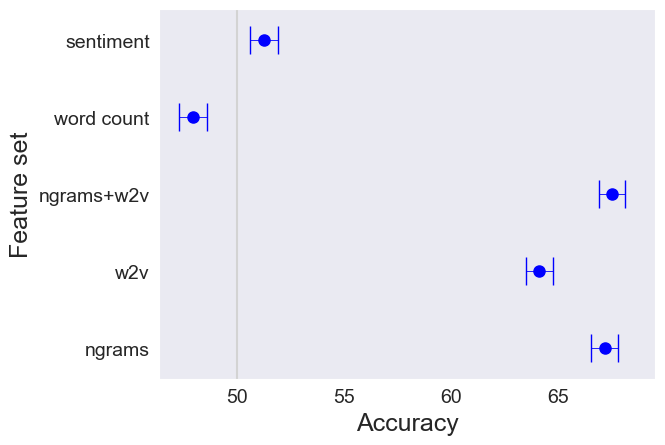

In [15]:
# Import the pyplot module from matplotlib library
from matplotlib import pyplot as plt

# Create a new figure
fig = plt.figure()

# Create an error bar plot
# The 'features' column in the 'plot_dat' DataFrame is used for the y-values
# The 'acc' column in the 'plot_dat' DataFrame is used for the x-values
# The 'err' column in the 'plot_dat' DataFrame is used for the x-error values
# The format of the markers is set to 'o', the color is set to 'b', the line width of the error bars is set to 0.6,
# the size of the markers is set to 8, and the length of the error bar caps is set to 10
plt.errorbar(y = plot_dat['features'], x = plot_dat['acc'], xerr=plot_dat['err'], fmt="o", color="b", elinewidth=.6, markersize=8, capsize=10)

# Turn off the grid
plt.grid(False)

# Add a vertical line at x=50
# The color of the line is set to 'lightgrey' and the line style is set to '-'
plt.axvline(x=50, color='lightgrey', linestyle='-')

# Add labels to the x and y axes
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Feature set', fontsize=18)

# Set the margins of the plot
# The x and y margins are set to 0.1
plt.margins(0.1, tight=True)

# Set the limits of the x-axis
# The right limit is set to the maximum accuracy plus the maximum error times 1.02
# The left limit is set to the minimum accuracy minus the minimum error times 0.98
plt.xlim(right=((max(plot_dat['acc']) + max(plot_dat['err']))) * 1.02,
         left=((min(plot_dat['acc']) - min(plot_dat['err']))) * 0.98)

# Set the font size of the x and y tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Display the plot
plt.show()